# Simple simulation of functional neuronal data
### joe@neuro.mpg.de

In [21]:
import numpy as np
# from scipy.stats import truncnorm
from scipy import ndimage

%matplotlib notebook
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## Simulated neuron imaging data!!!
For simulating data, it can help to think about the shape of the data you want at the end. 
In this case, it's a 3-dimensional array: n_timesteps, ypixels, xpixels
Then think of what goes into building each of the dimensions you need.
First we'll build up the x and y of the neurons' spatial footprints. 
Then create the timecourse for the neurons' activity. 

### Build spatial footprints

In [23]:
np.random.seed(0) # set our random seed, so we get random values (but consistent from run to run)
imsize = (256, 256)
n_neurons = 20
centers = np.vstack((np.random.uniform(0,imsize[0], n_neurons), np.random.uniform(0,imsize[1],n_neurons)))

#could potentially have non-overlapping centers https://scipython.com/blog/poisson-disc-sampling-in-python/
print(centers.shape)
print(centers)

[[140.49625701 183.08847779 154.30742427 139.49009485 108.45562863
  165.34889295 112.02232608 228.2938882  246.69766669  98.16102882
  202.68160975 135.39709946 145.41940764 236.9527394   18.1852309
   22.30510072   5.17590974 213.15068046 199.20812824 222.72310995]
 [250.52629561 204.58459244 118.13871674 199.81546913  30.27825302
  163.81978146  36.69844158 241.83524276 133.59317037 106.15345664
   67.7262367  198.2038245  116.77448505 145.51909091   4.81018891
  158.11468725 156.69650502 157.9351032  241.5995081  174.54599657]]
(2, 20)


array([5.79484792, 5.55187571, 8.28164795, 5.69091476, 5.98291181,
       6.84362585, 9.10496615, 5.48550638, 9.18972454, 5.48049204,
       9.88229733, 7.34325601, 9.88380544, 8.0242276 , 8.6963179 ,
       5.19593896, 6.41403481, 5.60098281, 6.48070099, 5.59363859])

<IPython.core.display.Javascript object>


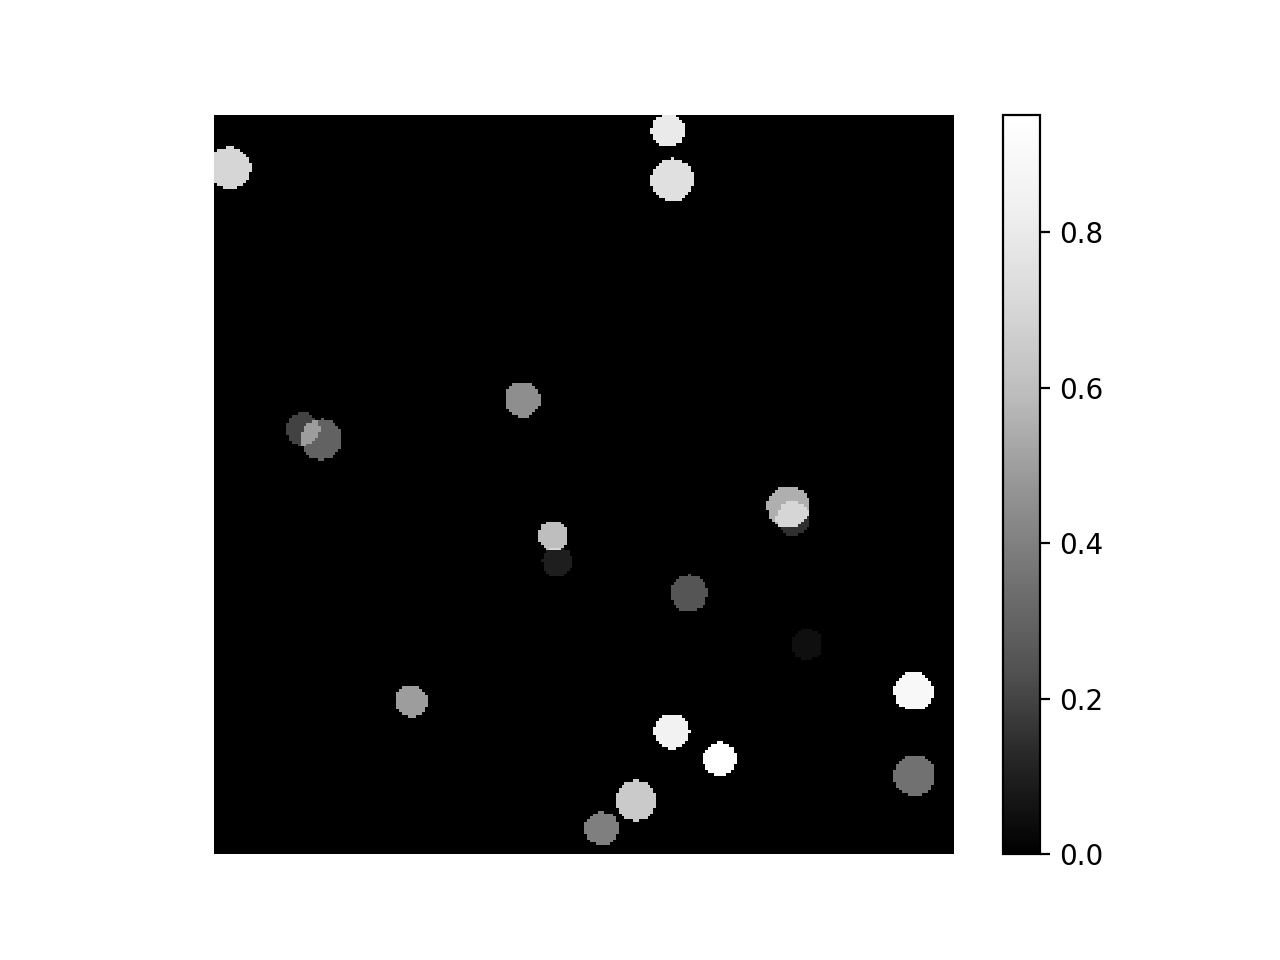

In [40]:
#Turn centers into spatial footprints (masks)
radii = np.random.uniform(5, 8, size=20) #Random radii

xx, yy = np.mgrid[0:imsize[0], 0:imsize[1]]
#Take distance from each center, and then threshold
neuron_footprints = (xx[..., None] - centers[0, :]) **2 + (yy[..., None] - centers[1, :]) **2 < radii**2

plt.figure()
plt.imshow((neuron_footprints * np.arange(n_neurons)).mean(-1), cmap=plt.cm.Greys_r)
plt.axis('off');
plt.colorbar()

### Have some 'stimuli' and each neuron is tuned to some of the stimuli

<IPython.core.display.Javascript object>


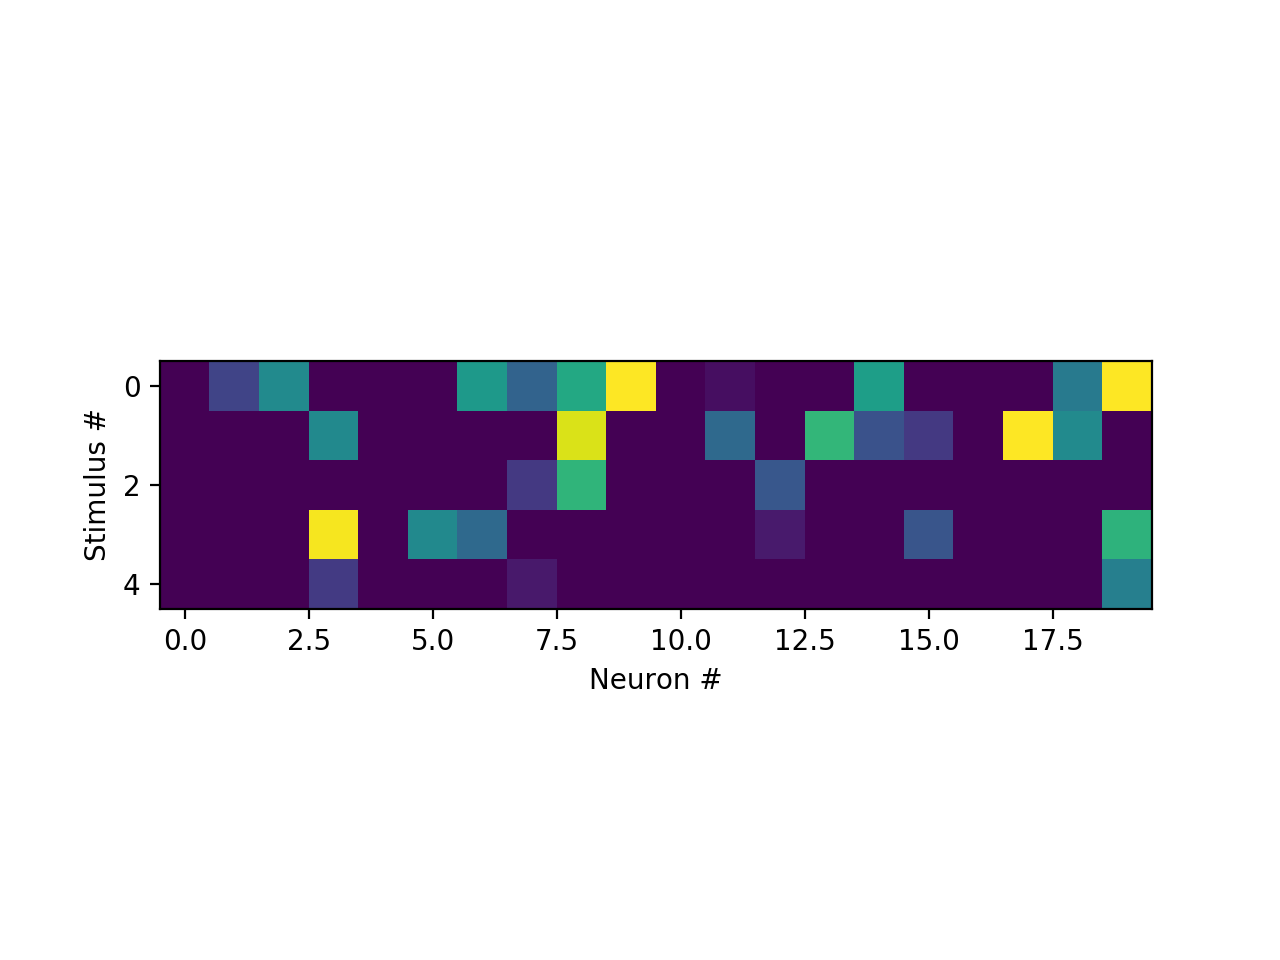

In [42]:
n_stimuli = 5 

tunings = np.random.uniform(size = (n_stimuli, n_neurons))
tunings[np.random.uniform(size=(n_stimuli, n_neurons)) < .7] = 0

plt.figure()
plt.imshow(tunings)
plt.xlabel('Neuron #')
plt.ylabel('Stimulus #');

### Each stimulus is repated multiple times

[2 1 4 0 3 4 0 3 2 1 0 2 4 1 3]
Stimulus order [2 1 4 0 3 4 0 3 2 1 0 2 4 1 3]


<IPython.core.display.Javascript object>


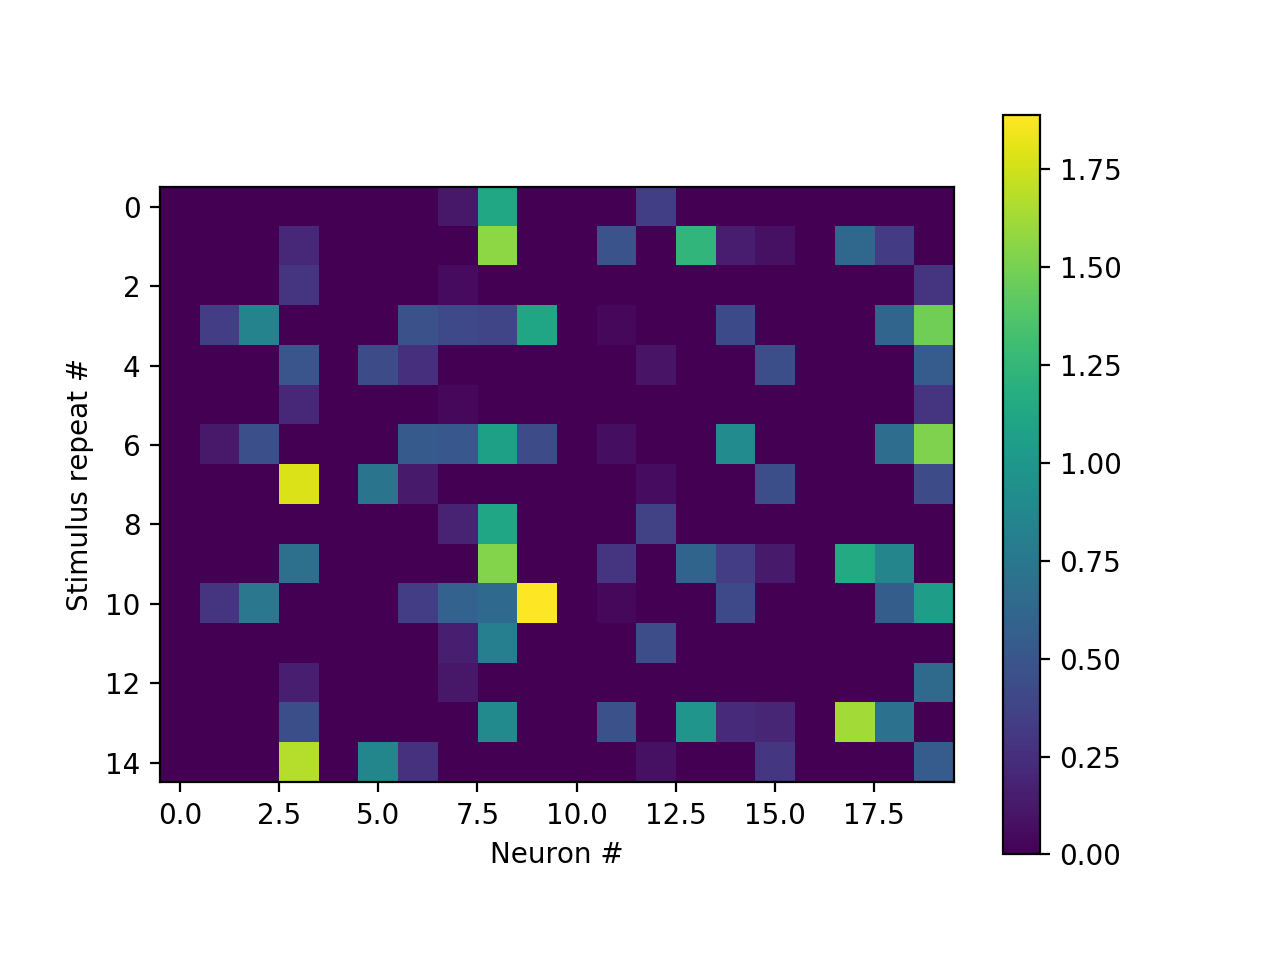

In [53]:
n_stimreps = 3 #number of times each stimulus is repeated 

# Generate pseudo-random ordering for stimuli
stim_order = np.random.random(size=(n_stimreps, n_stimuli)).argsort(axis=1)
print(stim_order.ravel())
print("Stimulus order {}".format(stim_order.ravel()))

# Encode the stimuli as 'one hot'
# a binary vector encoding which stimulus was presented at each time to make it easy to multiply with the tuning
onehotstim = np.zeros((stim_order.size, n_stimuli))
onehotstim[np.arange(stim_order.size), stim_order.ravel()] = 1
responses = np.dot(onehotstim, tunings)

# plt.figure()
# plt.imshow(onehotstim)
# plt.ylabel('Trial num')
# plt.xlabel('Stim #')

# add some response variability
responses *= np.random.uniform(.4, 2, size=responses.shape)

plt.figure()
plt.imshow(responses)
plt.colorbar()
plt.xlabel('Neuron #')
plt.ylabel('Stimulus repeat #');

### Now convert into a timeseries for each neuron

Stimulus frames:  [ 50  70  90 110 130 150 170 190 210 230 250 270 290 310 330]


<IPython.core.display.Javascript object>


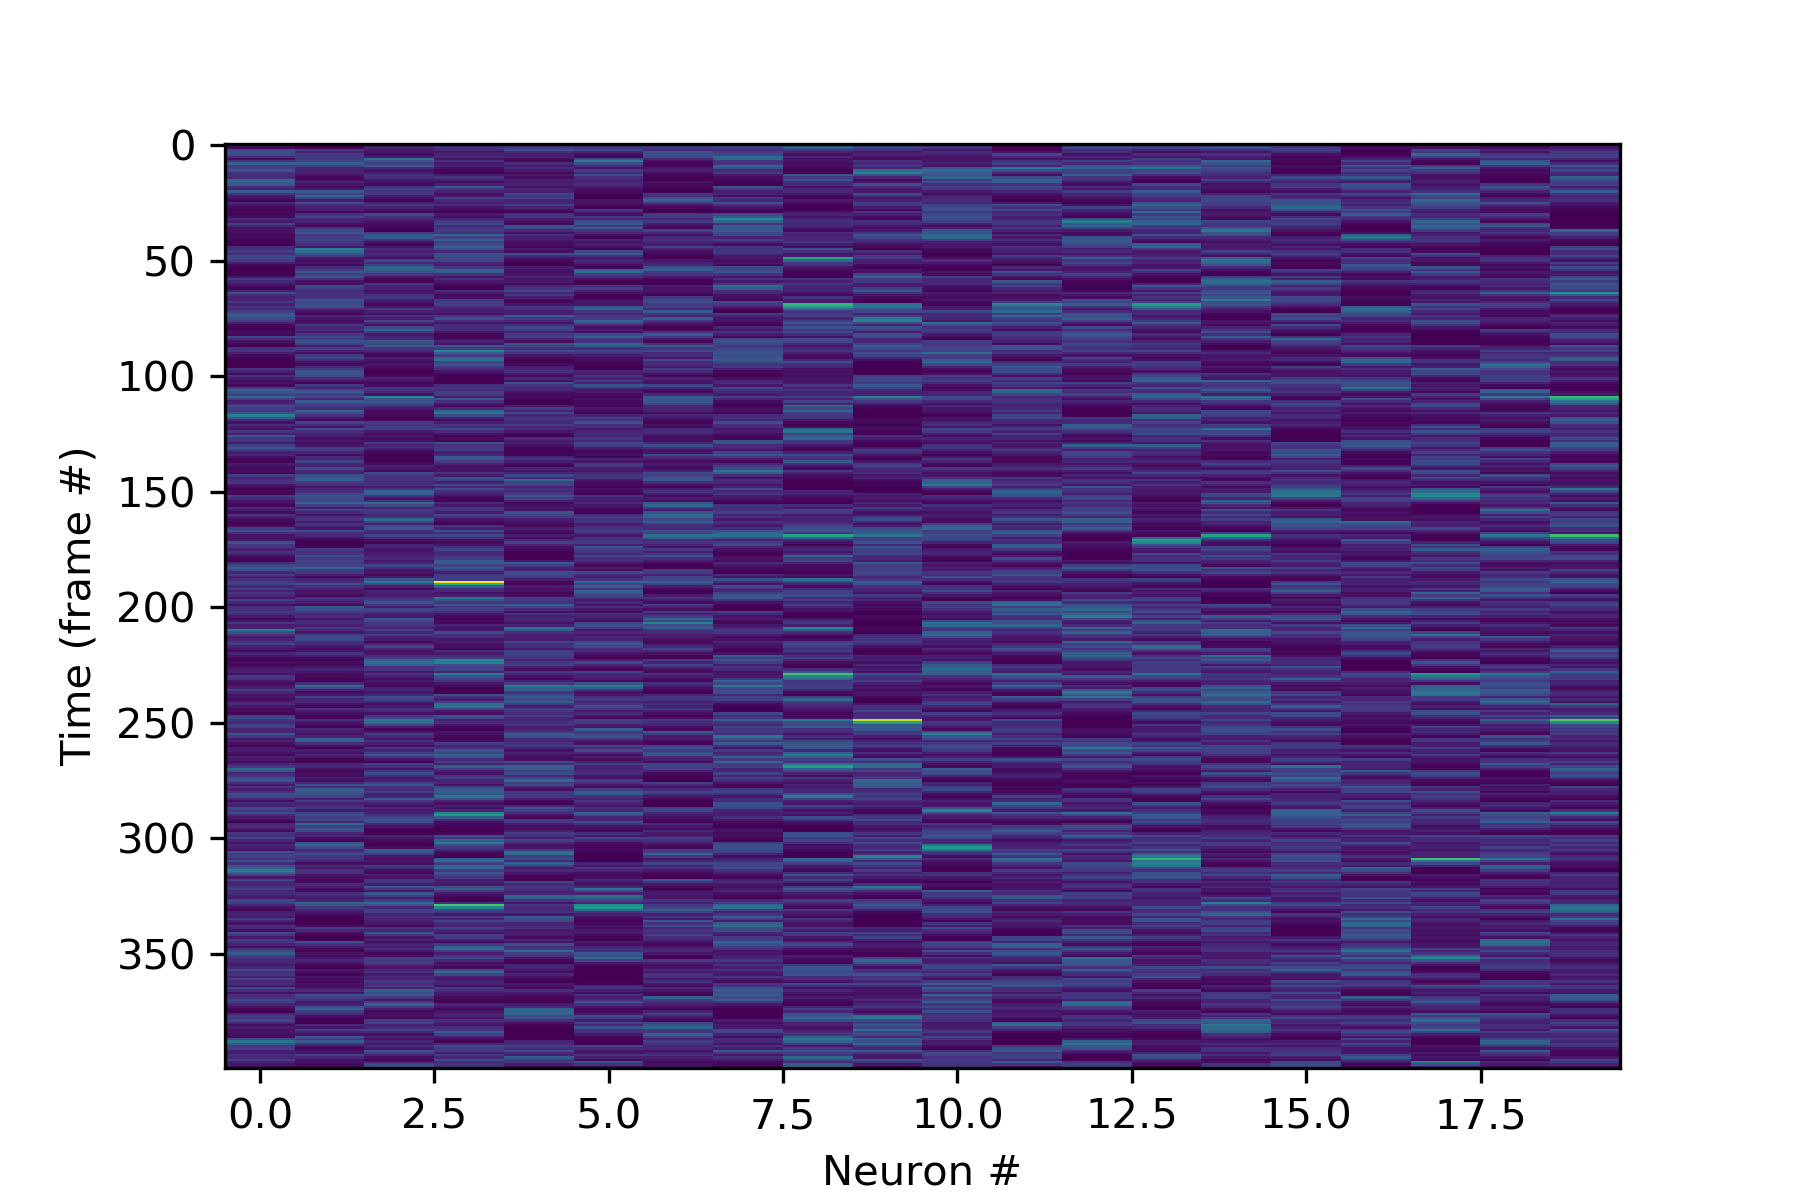

In [57]:
n_timesteps = 400
stimstart = 50
stimend = n_timesteps - 50

stim_times = (np.arange(stim_order.size)*(stimend-stimstart)/stim_order.size).astype(np.int) + stimstart
print("Stimulus frames: ", stim_times)
neuron_activity = np.zeros((n_timesteps, n_neurons))
neuron_activity[stim_times, :] = responses

# add some 'spontaneous' activity 
spont_activity = np.random.normal(.1, .3, size=neuron_activity.shape)
spont_activity[spont_activity<0] = 0
neuron_activity += spont_activity 

# Convolve to get slow gcamp sensor dynamics
x = np.linspace(0, 5, 5)
gcamp_kernel = np.exp(-x)*x
# plt.plot(x, gcamp_kernel)

neuron_activity = ndimage.convolve(neuron_activity, gcamp_kernel[:, None])

plt.figure(figsize=(6,4), dpi=150)
plt.imshow(neuron_activity, aspect='auto')
plt.xlabel('Neuron #')
plt.ylabel('Time (frame #)');

### And finally combine the neuron spatial footprints with the timeseries data

In [58]:
print(neuron_activity.shape, neuron_footprints.shape)
res = np.einsum('ij, abj -> iab', neuron_activity, neuron_footprints)
#Einsum is a neat but slightly tricky numpy function to efficiently multuply tensors (higher dimensional matricies)
print(res.shape)

# Add some imaging 'noise'
imaging_noise = np.random.normal(0, .2, size=res.shape)
imaging_noise[imaging_noise<0] = 0
res += imaging_noise


(400, 20) (256, 256, 20)
(400, 256, 256)


### Now we have simulated timeseries data

<IPython.core.display.Javascript object>


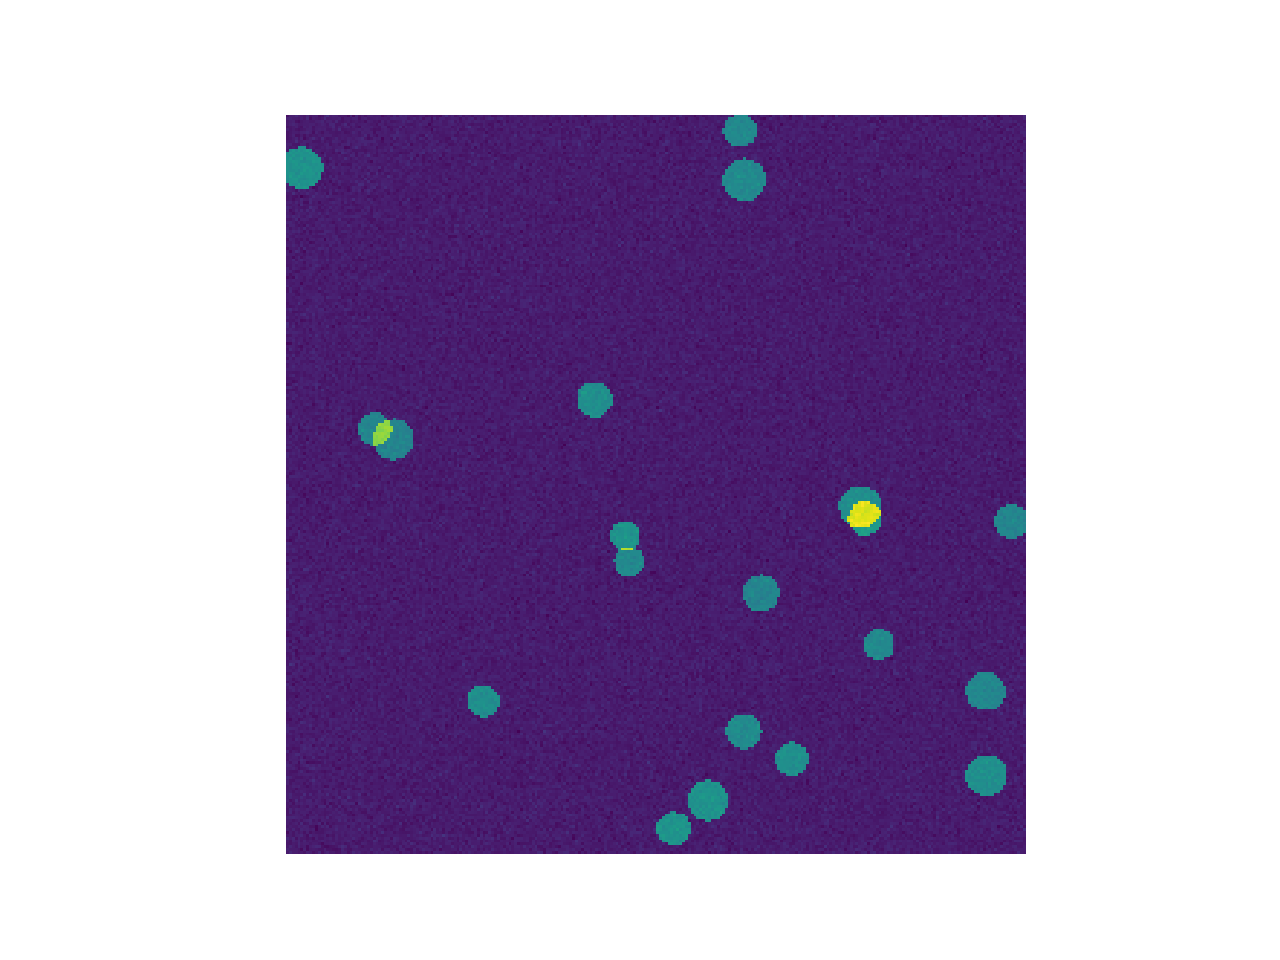

In [59]:
plt.figure()
plt.imshow(res.mean(axis=0))
plt.axis('off');

<IPython.core.display.Javascript object>


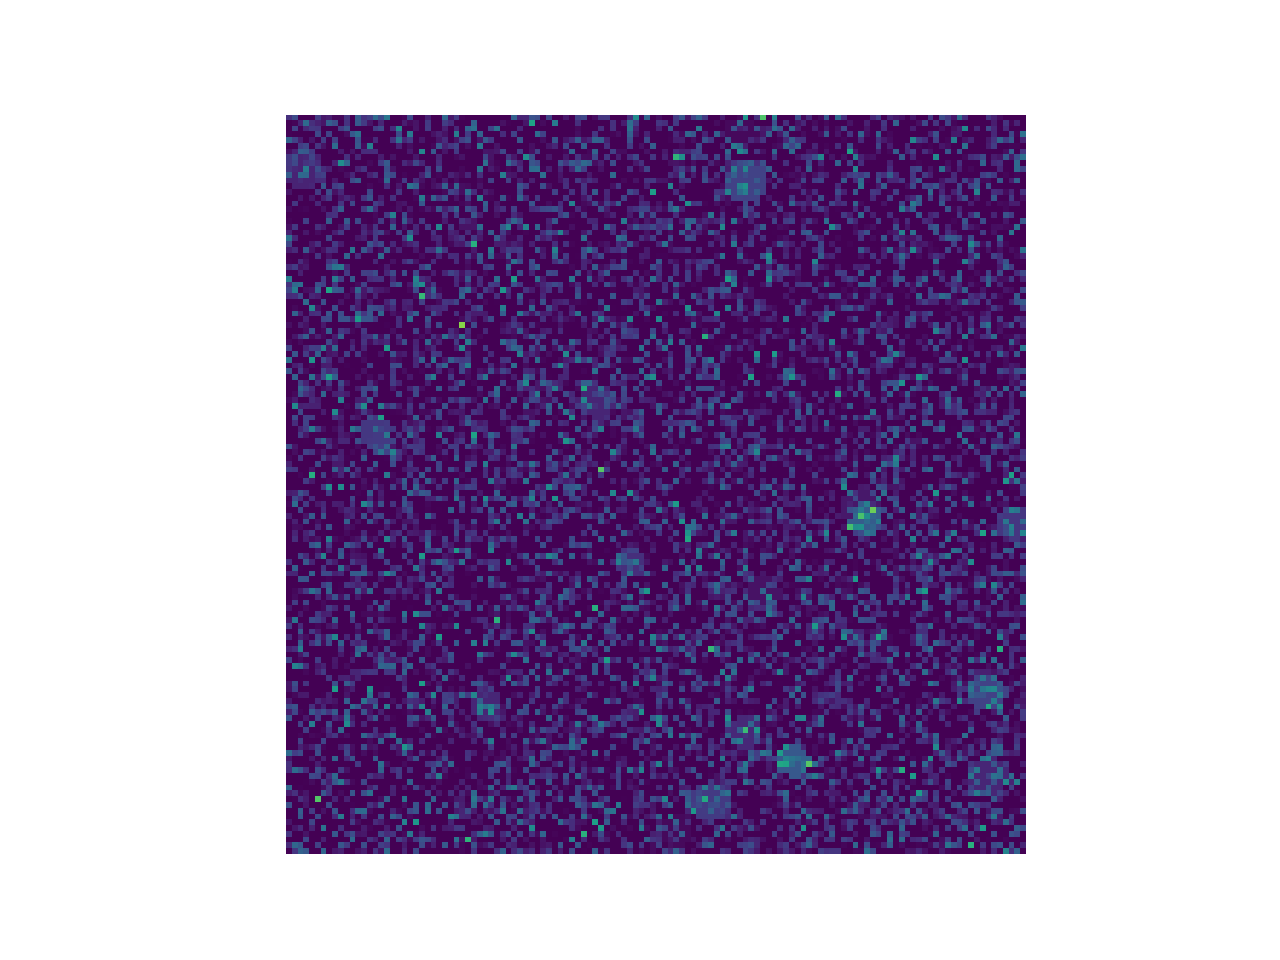

In [60]:
fig = plt.figure()
currentframe = 0
im = plt.imshow(res[currentframe, ::2, ::2], animated=True)
def updatefig(currentframe):
    im.set_array(res[currentframe, ::2, ::2])
    return im,

plt.axis('off')
ani = animation.FuncAnimation(fig, updatefig, frames=res.shape[0], interval=200, blit=True)
# HTML(ani.to_html5_video())

In [ ]:
# from skimage import io
# io.imsave('simtest.tif', (10000*res).astype(np.int16))

In [68]:
arr = np.asarray(250).astype(np.uint8)
result = (arr + 100).astype(np.uint8)
result

94

## Start of simple analysis (incomplete)

In [ ]:
# Extract data
reshaped = res.reshape(res.shape[0], -1)
decomp = decomposition.NMF(30, alpha=1, l1_ratio=.4)
# recov_timecourse = decomp.fit_transform(reshaped)
# # recov_timecourse = recov_timecourse[:, recov_timecourse.mean(axis=0).argsort()]
# recov_footprints = decomp.components_.reshape(-1, *imsize)

#TODO mean center
recov_footprints = decomp.fit_transform(reshaped.T).T.reshape(-1, *imsize)
recov_timecourse = decomp.components_.T


In [ ]:
plt.figure() 
plt.plot(recov_timecourse);

In [ ]:
plt.figure()
plt.imshow(recov_footprints[20, ...]);

In [ ]:
# explained_variance_score vs ncomps
np.var(res)

#check if comps are sorted
# plt.figure()
recov_footprints.shape
recov_timecourse.shape


In [ ]:
#TODO try doing all the above with xarray dask